In [25]:
import sys
import os
os.environ['PROJ_DATA'] = "/pscratch/sd/p/plutzner/proj_data"
import xarray as xr
import torch
import torchinfo
import random
import numpy as np
import importlib as imp
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cartopy.crs as ccrs
import json
import pickle
import gzip
#import matplotlib.colors as mcolorsxx

%load_ext autoreload
%autoreload 2
import utils
import utils.filemethods as filemethods
import databuilder.data_loader as data_loader
import databuilder.data_generator as data_generator
from databuilder.data_generator import ClimateData
import model.loss as module_loss
import model.metric as module_metric
from databuilder.data_generator import multi_input_data_organizer
import databuilder.data_loader as data_loader
from trainer.trainer import Trainer
from model.build_model import TorchModel
from utils import utils
# import databuilder.nino_indices as nino_indices # CAUSES CELL TO HANG

print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")
print(f"pytorch version = {torch.__version__}")

# https://github.com/victoresque/pytorch-template/tree/master

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
python version = 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]
numpy version = 1.26.4
xarray version = 2024.5.0
pytorch version = 2.0.0.post104


### Extract TEMP anomalies time series at Vancouver, BC

In [26]:
config = utils.get_config("exp005")
seed = config["seed_list"][0]

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

In [27]:
imp.reload(utils)
imp.reload(filemethods)
imp.reload(data_generator)

data = ClimateData(
    config["databuilder"], 
    expname = config["expname"],
    seed=seed,
    data_dir = config["data_dir"], 
    figure_dir=config["figure_dir"],
    target_only = True, 
    fetch=False,
    verbose=False
)

In [28]:
d_train, d_val, d_test = data.fetch_data()

Opening .nc files
Opening .nc files
Opening .nc files
Processing training
isolating variables from ds
Processing target output
Length of target = 60225
Shape of f_dict[key] after averaging across target region: (60225,)
Shape of f_dict[key] before seasonal cycle removal: (60225,)
<xarray.DataArray 'TS' (time: 40)> Size: 160B
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan], dtype=float32)
Coordinates:
  * time     (time) object 320B 1851-05-16 00:00:00 ... 1851-06-24 00:00:00
Shape of f_dict[key] after seasonal cycle removal: (0,)


ValueError: window shape cannot be larger than input array shape

In [ ]:
d_train["y"]

In [ ]:
import pickle
import gzip

data_savename1 = "/pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp005_d_train_WA_TS_1850-2014.pkl"
#data_savename1 = "/Users/C830793391/BIG_DATA/E3SM_Data/presaved/exp001_d_train.pkl"
with gzip.open(data_savename1, "wb") as fp:
    pickle.dump(d_train, fp)

data_savename2 = "/pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp005_d_val_WA_TS_1850-2014.pkl"
#data_savename2 = "/Users/C830793391/BIG_DATA/E3SM_Data/presaved/exp001_d_val.pkl"
with gzip.open(data_savename2, "wb") as fp:
    pickle.dump(d_val, fp)

data_savename3 = "/pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp005_d_test_WA_TS_1850-2014.pkl"
#data_savename3 = "/Users/C830793391/BIG_DATA/E3SM_Data/presaved/exp001_d_test.pkl"
with gzip.open(data_savename3, "wb") as fp:
    pickle.dump(d_test, fp)

Process + Pickle Inputs and Targets

In [759]:
# s_dict_train, s_dict_val, s_dict_test = multi_input_data_organizer(config, MJO = False, ENSO = True, PRECT_VC = True)

In [760]:
# s_dict_train["x"][50:140]

In [761]:
s_dict_savename1 = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp005_train.pkl'
# with gzip.open(s_dict_savename1, "wb") as fp:
#     pickle.dump(s_dict_train, fp)

s_dict_savename2 = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp005_val.pkl'
# with gzip.open(s_dict_savename2, "wb") as fp:
#     pickle.dump(s_dict_val, fp)

s_dict_savename3 = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp005_test.pkl'
# with gzip.open(s_dict_savename3, "wb") as fp:
#     pickle.dump(s_dict_test, fp)

with gzip.open(s_dict_savename1, "rb") as obj1:
    train_dat = pickle.load(obj1)
obj1.close()

with gzip.open(s_dict_savename2, "rb") as obj2:
    val_dat = pickle.load(obj2)
obj2.close()

with gzip.open(s_dict_savename3, "rb") as obj3:
    test_dat = pickle.load(obj3)
obj3.close()

In [762]:
train_dat["x"].shape

(60211, 2)

In [763]:
print(np.isnan(train_dat["x"][74:-32]).any())
print(np.isnan(val_dat["x"][74:-32]).any())
print(np.isnan(test_dat["x"][74:-32]).any())

print(np.isnan(train_dat["y"][74:-32]).any())
print(np.isnan(val_dat["y"][74:-32]).any())
print(np.isnan(test_dat["y"][74:-32]).any())

False
False
False
False
False
False


Retrieve Data: 


In [764]:
# Setup the Data
front_cutoff = config["databuilder"]["front_cutoff"] # remove front nans : 74 ENSO - two front nans before daily interpolation = 60 days, daily interpolation takes 1/2 the original time step = 15 days TOTAL = ~75
back_cutoff = config["databuilder"]["front_cutoff"]  # remove back nans 

trainset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp004_train.pkl", front_cutoff, back_cutoff)
valset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp004_val.pkl", front_cutoff, back_cutoff)

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=config["data_loader"]["batch_size"],
    shuffle=True,
    drop_last=False,
)

val_loader = torch.utils.data.DataLoader(
    valset,
    batch_size=config["data_loader"]["batch_size"],
    shuffle=False,
    drop_last=False,
)

X1 shape: (60063, 2)
Target shape: (60063,)
X1 shape: (60063, 2)
Target shape: (60063,)


Model Setup

In [765]:
# Setup the Model
model = TorchModel(
    config=config["arch"],
    target_mean=trainset.target.mean(axis=0),
    target_std=trainset.target.std(axis=0),
)
model.freeze_layers(freeze_id="tau")
optimizer = getattr(torch.optim, config["optimizer"]["type"])(
    model.parameters(), **config["optimizer"]["args"]
)
criterion = getattr(module_loss, config["criterion"])()
metric_funcs = [getattr(module_metric, met) for met in config["metrics"]]

# Build the trainer
device = utils.prepare_device(config["device"])
trainer = Trainer(
    model,
    criterion,
    metric_funcs,
    optimizer,
    max_epochs=config["trainer"]["max_epochs"],
    data_loader=train_loader,
    validation_data_loader=val_loader,
    device=device,
    config=config,
)

torch.backends.mps is available
tensor([1.], device='mps:0')


In [766]:
# Visualize the model
torchinfo.summary(
    model,
    [   trainset.input[: config["data_loader"]["batch_size"]].shape ],
    verbose=1,
    col_names=("input_size", "output_size", "num_params"),
)

# Train the Model
model.to(device)
trainer.fit()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
TorchModel                               [64, 2]                   [64, 4]                   62
├─Linear: 1-1                            [64, 2]                   [64, 6]                   18
├─Linear: 1-2                            [64, 6]                   [64, 4]                   28
Total params: 108
Trainable params: 103
Non-trainable params: 5
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
Epoch   0/3000
  8.1s - loss: 4.13366 - val_loss: 4.13424
Epoch   1/3000
  7.7s - loss: 4.12657 - val_loss: 4.12757
Epoch   2/3000
  7.5s - loss: 4.12000 - val_loss: 4.12107
Epoch   3/3000
  7.5s - loss: 4.11332 - val_loss: 4.11465
Epoch   4/3000
  7.9s - loss: 4.10711 - val_loss: 4.10821
Epoch   5/3000
  7.5s - loss: 4.10024 - val_loss: 4.10174
Epoch   6/3000
  7.5s - loss: 4.09340 - val_loss: 4.09516


dict_keys(['epoch', 'loss', 'val_loss', 'custom_mae', 'iqr_capture', 'sign_test', 'val_custom_mae', 'val_iqr_capture', 'val_sign_test'])


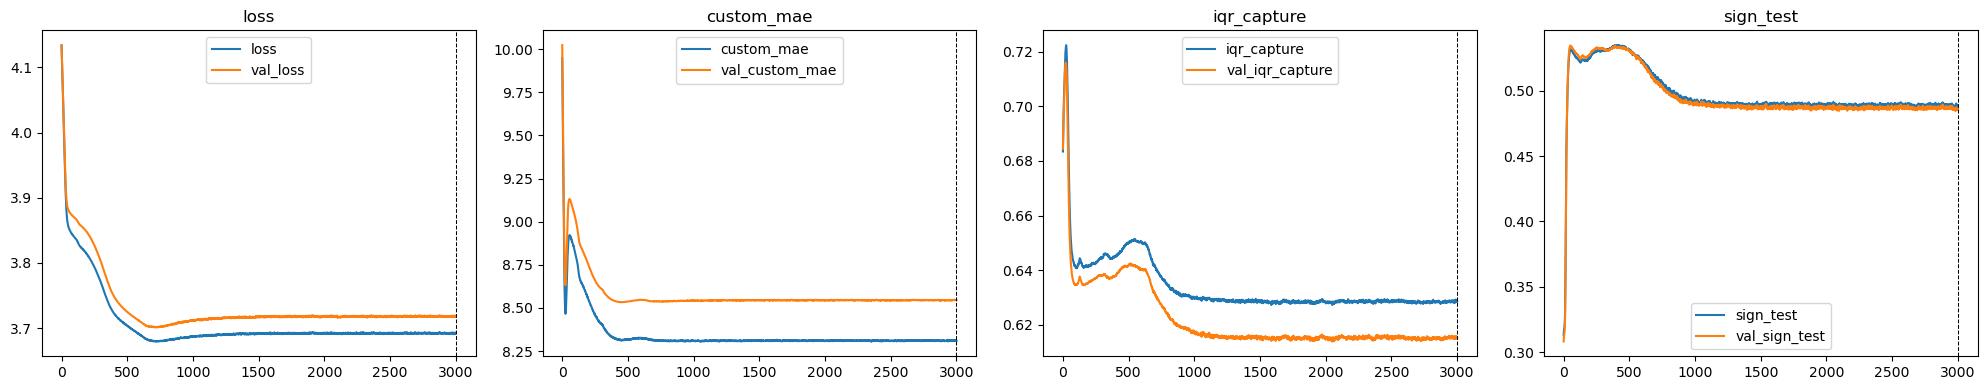

In [767]:
print(trainer.log.history.keys())

plt.figure(figsize=(20, 4))
for i, m in enumerate(("loss", *config["metrics"])):
    plt.subplot(1, 4, i + 1)
    plt.plot(trainer.log.history["epoch"], trainer.log.history[m], label=m)
    plt.plot(
        trainer.log.history["epoch"], trainer.log.history["val_" + m], label="val_" + m
    )
    plt.axvline(
       x=trainer.early_stopper.best_epoch, linestyle="--", color="k", linewidth=0.75
    )
    plt.title(m)
    plt.legend()
plt.tight_layout()
plt.show()

Plot Predictions Against Climatology: 

In [777]:
with torch.inference_mode():
    print(device)
    output = model.predict(dataset=valset, batch_size=128, device=device)
output[:20]

mps


array([[-3.1248946 , 12.506565  ,  0.27346838,  1.        ],
       [-3.1249378 , 12.505836  ,  0.27331156,  1.        ],
       [-3.2753863 , 10.203824  , -0.27367443,  1.        ],
       [-3.2753863 , 10.203824  , -0.27367443,  1.        ],
       [-3.2753863 , 10.203824  , -0.27367443,  1.        ],
       [-3.2753863 , 10.203824  , -0.27367443,  1.        ],
       [-3.2753863 , 10.203824  , -0.27367443,  1.        ],
       [-3.2753863 , 10.203824  , -0.27367443,  1.        ],
       [-3.2753863 , 10.203824  , -0.27367443,  1.        ],
       [-3.2753863 , 10.203824  , -0.27367443,  1.        ],
       [-3.2753863 , 10.203824  , -0.27367443,  1.        ],
       [-3.2753863 , 10.203824  , -0.27367443,  1.        ],
       [-3.2753863 , 10.203824  , -0.27367443,  1.        ],
       [-3.2753863 , 10.203824  , -0.27367443,  1.        ],
       [-3.2753863 , 10.203824  , -0.27367443,  1.        ],
       [-3.2753863 , 10.203824  , -0.27367443,  1.        ],
       [-3.2753863 , 10.

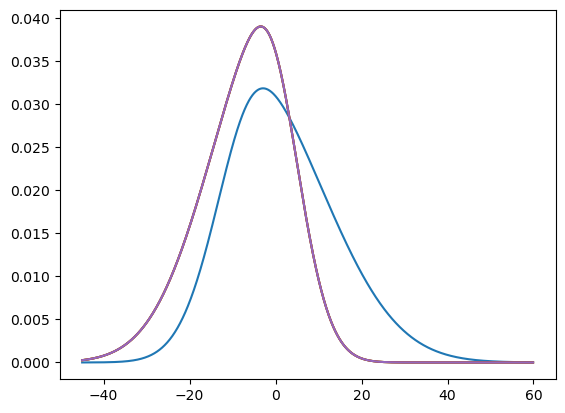

In [778]:
from shash.shash_torch import Shash
# params = np.zeros((2,4))
# # mu = 0; sigma=1., gamma=0, tau=1
# params[:,1] = 1.
# params[:,-1] = .003
# s = Shash(params)
s = Shash(output)

x = np.arange(-45,60,.1)
y = s.prob(x)
np.shape(y)

for i in (1, 2, 3, 4, 5):
    plt.plot(x, y[:,i])

tensor([-1.6354, -0.0265, -2.8445, -2.7248, 20.9809])


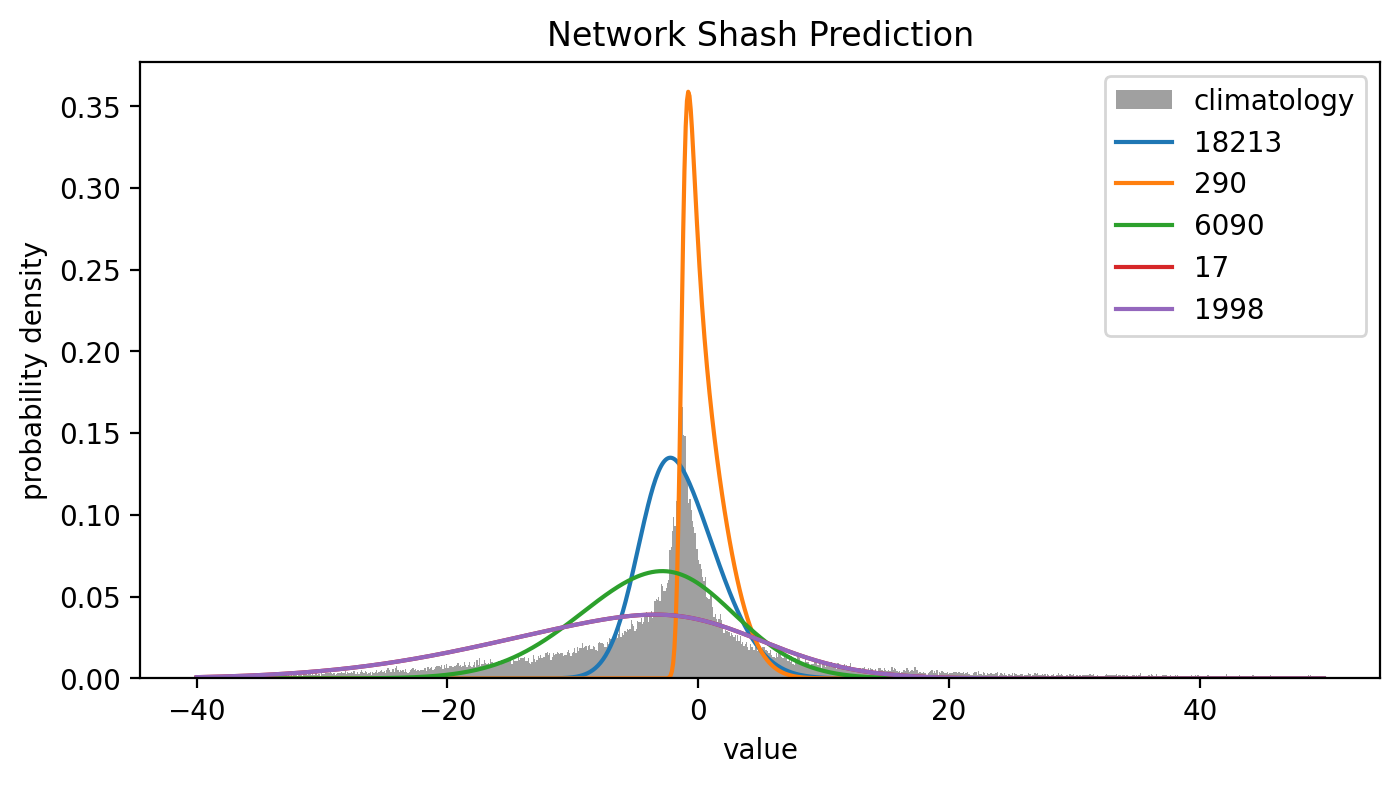

In [784]:
from databuilder.climatology import deriveclimatology

samples = [18213, 290, 6090, 17, 1998]

x = np.arange(-40, 50, 0.1)

cfile = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp002_test.pkl'

p = deriveclimatology(output, cfile, samples, x, valset)


In [785]:
valset.target[290]

-0.026514933423712122

In [772]:
valset.target[18213]

-1.6353523363523854

In [773]:
valset.target[1998]

20.98091208896154

In [774]:
valset.target[6090]

-2.844547247735154

In [775]:
valset.target[17]

-2.7247618169944414

In [776]:
valset.target[0]

9.173210320182852